In [59]:
from __future__ import annotations
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from sklearn import metrics,linear_model
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

FILE = 'data'
listErrors = {}


In [60]:
def plotResults(errors: dict, title):
    plt.figure(figsize=(20, 3))
    plt.bar(*zip(*errors.items()))
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Error")
    plt.show()


# Obtención de datos
Obtenemos los datos con valores perdidos y el conjunto de datos limpios

In [61]:
data = pd.read_csv('%s/winequality-white-missing.csv' %FILE, sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4400 non-null   float64
 1   volatile acidity      4431 non-null   float64
 2   citric acid           4411 non-null   float64
 3   residual sugar        4434 non-null   float64
 4   chlorides             4387 non-null   float64
 5   free sulfur dioxide   4398 non-null   float64
 6   total sulfur dioxide  4429 non-null   float64
 7   density               4413 non-null   float64
 8   pH                    4415 non-null   float64
 9   sulphates             4372 non-null   float64
 10  alcohol               4412 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


In [62]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4400.000000,4431.000000,4411.000000,4434.000000,4387.000000,4398.000000,4429.000000,4413.000000,4415.000000,4372.000000,4412.000000,4898.000000
mean,6.849080,0.277857,0.334670,6.393223,0.046018,35.394839,137.756266,0.994038,3.188061,0.489879,10.518351,5.877909
std,0.835875,0.100151,0.122274,5.086485,0.022396,17.092922,42.078770,0.003014,0.151680,0.114343,1.234730,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.740000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991740,3.080000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993800,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.850000,0.050000,46.000000,166.000000,0.996120,3.280000,0.550000,11.400000,6.000000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [63]:
originalData = pd.read_csv('%s/winequality-white.csv' %FILE, sep=";")
originalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [64]:
originalData.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


El método *getError* se encargará de comparar mediante el error cuadratico medio el conjunto de los datos imputado con uno de los dos métodos y el conjunto de datos limpios.

In [65]:
def getError(tableA, tableB, keys):
    errors = { key:metrics.mean_squared_error(
        tableA[key], 
        tableB[key]
    ) for key in keys}
    return errors

La clase *Column* almacena la información relativa a las columnas con valores perdidos

In [66]:
class Column():
    def __init__(self, key:str,positionalLostValues:pd.Series,index:int):
       self.key = key
       self.positionalLostValues = positionalLostValues
       self.index = index


El método *getColumnsWithNulls* se encargará de extraer las columnas con nulos

In [67]:
def getColumnsWithNulls(df: pd.DataFrame) -> list:
    return [
        Column(key, data[key].isnull(), idx) for idx,key in enumerate(df)
        if any(data[key].isnull())
    ]

Como es algo recurente en ambos métodos exite un método para la imputación de valores mediante la media

In [68]:
def meanImputation(meanImputationData: pd.DataFrame, columnsNulls: list) -> None:
    for col in columnsNulls:
        meanImputationData.loc[col.positionalLostValues, col.key] = meanImputationData.loc[~col.positionalLostValues, col.key].mean()

## Imputación MICE

1.  Se realiza una imputación simple en cada variable con valores perdidos mediante la medina
2.  Se Selecciona una variable xi con valores perdidos y se vuelve a cambiar los valores imputados por los perdidos.
3.  Se realiza una estimación (regresión), usando como variable respuesta xi y como variables predictoras el resto.  Los valores perdidos en xi se sustituyen por las estimaciones obtenidas en el paso 3. 
5.  Se repiten los pasos 2-4 para cada variable con valores perdidos (un ciclo).
6.  Se repite un determinado número de ciclos.

El algoritmo se encuentra recogido en el método *miceImputation*

In [69]:
def LinearImputation(LinearImputationData: pd.DataFrame, colum: Column):
    matLost = LinearImputationData[colum.positionalLostValues].values
    matNotLost = LinearImputationData[~colum.positionalLostValues].values
    listIndex = list(range(len(LinearImputationData.keys())-1))
    listIndex.remove(colum.index)
    xLost = matLost[:,listIndex]
    x = matNotLost[:, listIndex]
    yHat = matNotLost[:,colum.index]
    model = linear_model.LinearRegression()
    model.fit(x,yHat)
    LinearImputationData.loc[colum.positionalLostValues, colum.key] = model.predict(xLost)

In [70]:
def miceImputation(df:pd.DataFrame, iters: int) -> pd.DataFrame:
    miceImputationData = df.copy()
    columnsNulls = getColumnsWithNulls(miceImputationData)
    meanImputation(miceImputationData, columnsNulls)
    for _ in range(iters):
        for col in columnsNulls:
            LinearImputation(miceImputationData, col)
    return miceImputationData

A la hora de comparar los resultados vemos que la imputación ha generado valores similares.

In [71]:
result = miceImputation(data, 100)
result.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.849376,0.277632,0.334760,6.396540,0.045914,35.338499,138.065889,0.994027,3.188215,0.489780,10.514622,5.877909
std,0.819329,0.096033,0.116968,5.037227,0.021448,16.981656,41.297176,0.002991,0.147836,0.108802,1.221027,0.885639
min,3.800000,0.043670,0.000000,-1.010270,0.009000,-185.065224,9.000000,0.986933,2.740000,0.220000,5.753723,3.000000
25%,6.300000,0.220000,0.270000,1.800000,0.036000,24.000000,109.000000,0.991740,3.090000,0.420000,9.500000,5.000000
50%,6.800000,0.265000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993770,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.320000,0.380000,9.850000,0.050000,45.024964,166.000000,0.996100,3.274035,0.540000,11.400000,6.000000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [72]:
originalData.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [73]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


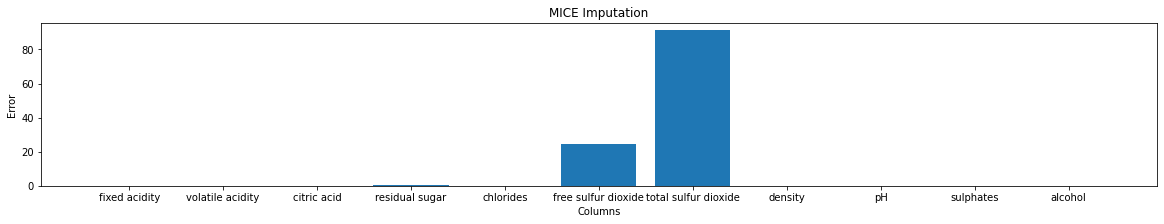

In [74]:
err = getError(result, originalData, data.keys()[:-1])
plotResults(err, "MICE Imputation")

Vemos que en general para todos los atributos se generan un buen resultado, exectuando para las columnas **free sulfur dioxide** y **total sulfur dioxide** donde su error se mantiene bastante alto.

## Imputación mediante HOT-DECK

Se sustituyen los valores perdidos por el valor que posee la muestra más próxima(utilizando la distancia euclídea) considerando todos los atributos excepto el que contiene valores perdidos. Como la mayoria de atributos tienen valores perdidos se utiliza una imputación mediante la mediana como primer paso


In [75]:
def calculateIndicesToSubstitute(hotDeckImputationData: pd.DataFrame, colum: Column):
    matLost = hotDeckImputationData[colum.positionalLostValues].values
    matNotLost = hotDeckImputationData[~colum.positionalLostValues].values
    listIndex = list(range(len(hotDeckImputationData.keys())-1))
    listIndex.remove(colum.index)
    dfLostValues = matLost[:,listIndex]
    dfValues = matNotLost[:, listIndex]

    euclidianDistances = [
        [np.linalg.norm(vecLost-vecValues) for vecValues in dfValues]
        for vecLost in dfLostValues
    ]
    return [ np.where(vecDists == np.amin(vecDists))[0][0] for vecDists in euclidianDistances]


In [76]:
def hotDeck(df: pd.DataFrame):
    hotDeckImputationData = df.copy()
    columnsNulls = getColumnsWithNulls(hotDeckImputationData)
    meanImputation(hotDeckImputationData, columnsNulls)
    for col in columnsNulls:
        hotDeckImputationData.loc[col.positionalLostValues, col.key] = hotDeckImputationData[col.key][
            calculateIndicesToSubstitute(hotDeckImputationData, col)].values
    return hotDeckImputationData

In [77]:
df = hotDeck(data)

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   float64
dtypes: float64(12)
memory usage: 459.3 KB


In [79]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.853472,0.276941,0.334582,6.469450,0.046022,35.497352,137.665888,0.994047,3.188703,0.489864,10.516796,5.877909
std,0.825343,0.098779,0.121124,5.132892,0.022630,16.948334,42.065868,0.002987,0.151324,0.114470,1.230285,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.740000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.800000,0.036000,23.000000,108.000000,0.991760,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.400000,0.043000,34.000000,134.000000,0.993800,3.180000,0.480000,10.400000,6.000000
75%,7.300000,0.320000,0.380000,9.900000,0.050000,46.000000,166.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,11.800000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [80]:
originalData.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


{'fixed acidity': 0.14451865517839757, 'volatile acidity': 0.0016750267706102451, 'citric acid': 0.002485667670014679, 'residual sugar': 5.526795140408148, 'chlorides': 8.768830064168968e-05, 'free sulfur dioxide': 46.58821544930685, 'total sulfur dioxide': 341.6801853332404, 'density': 1.4274638175669628e-06, 'pH': 0.0042521755851831315, 'sulphates': 0.002809462398948994, 'alcohol': 0.281659167383782}


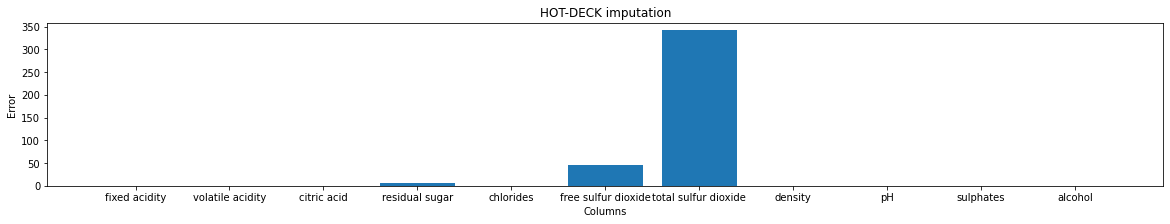

In [81]:
err = getError(df, originalData, data.keys()[:-1])
plotResults(err, "HOT-DECK imputation")

Vemos que en general para todos los atributos se generan un buen resultado, exectuando para las columnas **free sulfur dioxide** y **total sulfur dioxide** donde su error se mantiene bastante alto. Ocurre el mismo resultado que con el anterior método tan solo que utilizando Hot-Deck se consigue un mayor rango de error.

## Conclusiones

1 . Mice con LR mejor
2. Error alto en las dos columnas esas debido a que son idependientes
3. Mostar matriz de confución con eso

In [82]:
import seaborn as sn

sn.heatmap(originalData, annot=True)
plt.show()

KeyboardInterrupt: 